
# Translation with a Sequence to Sequence Network and Attention

In this project we will be teaching a neural network to translate from
French to English.

::

    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... to varying degrees of success.

This is made possible by the simple but powerful idea of the [sequence
to sequence network](https://arxiv.org/abs/1409.3215)_, in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

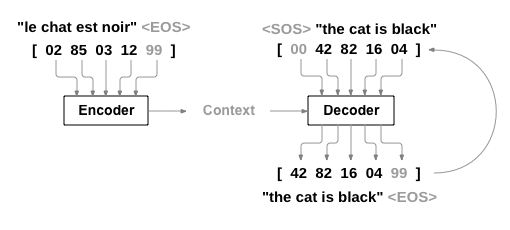

To improve upon this model we'll use an [attention
mechanism](https://arxiv.org/abs/1409.0473)_, which lets the decoder
learn to focus over a specific range of the input sequence.

**Recommended Reading:**


It would also be useful to know about Sequence to Sequence networks and
how they work:

-  [Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation](https://arxiv.org/abs/1406.1078)_
-  [Sequence to Sequence Learning with Neural
   Networks](https://arxiv.org/abs/1409.3215)_
-  [Neural Machine Translation by Jointly Learning to Align and
   Translate](https://arxiv.org/abs/1409.0473)_
-  [A Neural Conversational Model](https://arxiv.org/abs/1506.05869)_


**Requirements**


Import libraries

In [7]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading data files

The data for this project is a set of many thousands of English to
French translation pairs.

The English to French pairs are too big to include in the repo, so
download to ``eng-fra.txt`` before continuing. The file is a tab
separated list of translation pairs:

::

    I am cold.    J'ai froid.


we will be representing each word in a language as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. We will however cheat a bit and trim the data to only use a few
thousand words per language.

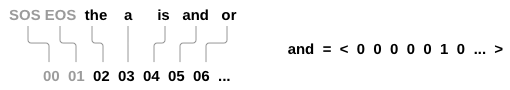





We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` which will be used to replace rare words later.




This code block defines a class called Lang that represents a language. It has attributes such as a name, word-to-index dictionary, word-to-count dictionary, index-to-word dictionary, and the number of words in the language. The class has methods to add a sentence to the language and add a new word to the language. The language initializes with two special tokens, SOS (Start of Sentence) and EOS (End of Sentence), and counts them as part of the language's vocabulary.






In [8]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




This code block contains two functions: "unicodeToAscii" and "normalizeString". The "unicodeToAscii" function takes a Unicode string as input and returns the corresponding ASCII string. The "normalizeString" function takes a string as input, converts it to lowercase, removes leading and trailing whitespaces, and removes any non-letter characters except for periods, exclamation marks, and question marks. It uses the "unicodeToAscii" function to convert any Unicode characters to ASCII before performing the normalization. The resulting string is returned by the function.






In [9]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




This code block defines a function called "readLangs" that reads a text file containing pairs of sentences in two languages (lang1 and lang2). It normalizes the text by calling the "normalizeString" function on each sentence pair. It then creates instances of the Lang class (defined in a previous code block) for each language and returns these instances along with the normalized sentence pairs. If the "reverse" parameter is set to True, it swaps the language pairs and creates Lang instances accordingly. The function also prints "Reading lines..." to the console as a progress indicator.






In [10]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




This code block defines a maximum sentence length (MAX_LENGTH) and a set of English language prefixes (eng_prefixes). It also defines two functions for filtering sentence pairs. The first function "filterPair" takes a sentence pair (p) as input and returns True if the length of the first sentence (p[0]) and the second sentence (p[1]) are both less than MAX_LENGTH and the second sentence (p[1]) starts with one of the English prefixes defined in "eng_prefixes". Otherwise, it returns False. The second function "filterPairs" takes a list of sentence pairs (pairs) as input and applies the "filterPair" function to each pair, returning a new list containing only the pairs that pass the filter. The purpose of these functions is to filter out sentence pairs that are too long or do not match the expected format.






In [11]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




This code block defines a function "prepareData" that uses the previously defined functions to read sentence pairs from a text file, filter them based on sentence length and prefix, and count the words in each language. It then returns instances of the Lang class for both input and output languages along with the filtered sentence pairs. The function also prints some status messages to the console for progress indication.

After defining the function, it calls the "prepareData" function to read and prepare English to French sentence pairs with the English and French languages swapped (reverse=True). Finally, it randomly selects and prints a single sentence pair from the prepared data using the "random.choice" function.

In [12]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je viens de turquie .', 'i m from turkey .']


## The Seq2Seq Model

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A [Sequence to Sequence network](https://arxiv.org/abs/1409.3215)_, or
seq2seq network, or [Encoder Decoder
network](https://arxiv.org/pdf/1406.1078v3.pdf)_, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

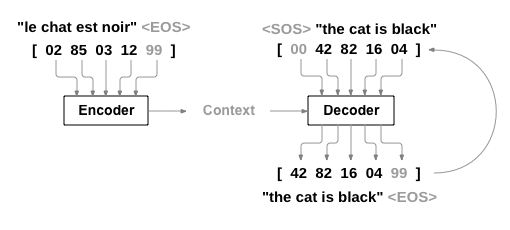

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




### The Encoder

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

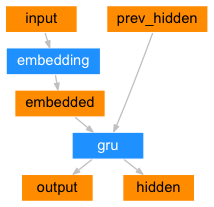





This code block defines an Encoder module for a sequence-to-sequence model in PyTorch, which uses an embedding layer and GRU cells to encode an input sequence into a fixed-length vector representation.






In [13]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### The Decoder

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




#### Simple Decoder

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).

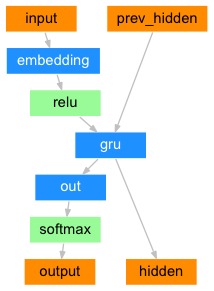





This code block defines a DecoderRNN class that inherits from the PyTorch nn.Module class. It defines the architecture of the decoder RNN for a sequence-to-sequence model. The decoder takes the encoded input and generates an output sequence. It uses an embedding layer to transform the input to a fixed-size hidden state, a GRU layer to process the hidden state, and a linear layer and softmax activation to produce a probability distribution over the output vocabulary. The initHidden method initializes the hidden state of the decoder RNN with zeros.






In [14]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

I encourage you to train and observe the results of this model, but to
save space we'll be going straight for the gold and introducing the
Attention Mechanism.




#### Attention Decoder

If only the context vector is passed between the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

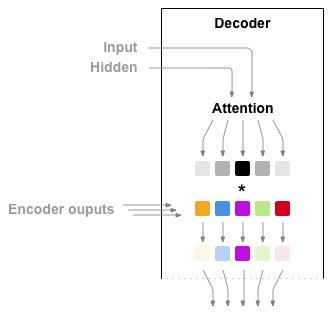

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

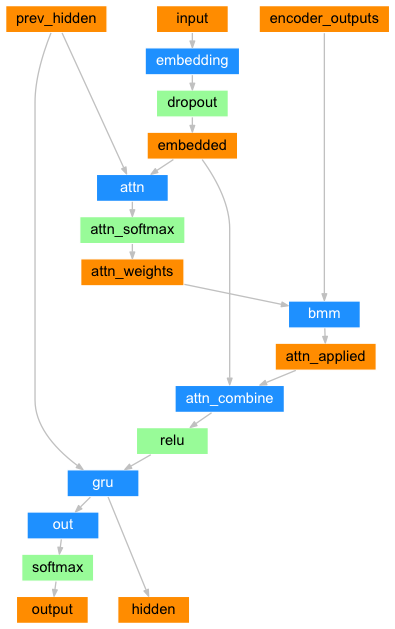





This code defines a class AttnDecoderRNN which inherits from nn.Module. This class implements an attention-based decoder recurrent neural network for sequence-to-sequence translation. It takes as input an embedding of the previous target token, a hidden state from the previous time step, and the encoder outputs. It uses a linear layer to compute attention weights, applies these weights to the encoder outputs to get an attention context vector, concatenates this context vector with the input embedding, applies a linear layer to obtain the input to the GRU cell, passes the input through the GRU cell, applies a linear layer to obtain the output logits, and finally applies a log-softmax function to get the output probabilities. The class also defines an initHidden method to initialize the hidden state of the decoder.






In [15]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

<div class="alert alert-info"><h4>Note</h4><p>There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in [Effective Approaches to Attention-based Neural Machine
  Translation](https://arxiv.org/abs/1508.04025)_.</p></div>

## Training

### Preparing Training Data

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




This code block defines three functions that are used to convert a sentence or a pair of sentences into tensors. The indexesFromSentence function takes in a language object and a sentence, splits the sentence into individual words, and returns a list of word indices for the corresponding language. The tensorFromSentence function uses the indexesFromSentence function to get the word indices for a sentence, appends an end-of-sentence token, and returns a tensor of the resulting indices. The tensorsFromPair function uses the tensorFromSentence function to get tensors for the input and target sentences in a pair.






In [16]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### Training the Model

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but [when the trained
network is exploited, it may exhibit
instability](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf)_.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




This code block defines a training function for a sequence-to-sequence model using a teacher-forcing technique. It takes as input an input tensor, target tensor, encoder, decoder, optimizer, criterion, and maximum length.

During training, the encoder takes the input tensor and produces outputs, which are stored in a tensor. Then, the decoder takes the encoder outputs and the target tensor to produce predictions. If teacher-forcing is enabled, the target tensor is used as input for the decoder; otherwise, the decoder's own predictions are used. The function computes the loss between the decoder's predictions and the target tensor and backpropagates the loss to update the model's parameters.

The function returns the average loss per target word.

In [17]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




This code block defines two functions asMinutes and timeSince used for time-related operations. asMinutes takes a duration in seconds and returns a string representation of that duration in minutes and seconds format. timeSince takes two arguments, a since timestamp and a percent value, and returns a string representation of the time elapsed since the since timestamp, as well as the estimated remaining time until the percent value is reached.






In [18]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




This code block defines a function trainIters() that trains an encoder-decoder model for a specified number of iterations (n_iters). It initializes optimizer objects for the encoder and decoder models with a specified learning rate. It also creates training pairs and uses them to compute the loss and optimize the model parameters. The function prints the average loss every print_every iterations and stores the average loss every plot_every iterations for plotting later. The function also calls showPlot() function to display a plot of the loss over time.






In [19]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### Plotting results

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




This code block defines a function showPlot() that uses the matplotlib library to plot a graph of a list of points. The function creates a figure, sets the y-axis tick interval to be 0.2, and plots the points on the graph. The plt.switch_backend('agg') line is used to set the backend of matplotlib to agg, which is a non-interactive backend suitable for server-side applications.






In [20]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## Evaluation

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




This code block defines a function called evaluate that takes an encoder, a decoder, a sentence, and an optional maximum length parameter as input. The function first converts the input sentence into a tensor using the tensorFromSentence function, initializes the encoder hidden state, and creates an empty tensor to hold the encoder outputs. It then runs the encoder over the input sentence and stores the encoder outputs in the tensor.

Next, the function initializes the decoder hidden state with the final encoder hidden state and creates a tensor with a start-of-sequence token (SOS). It then runs the decoder over the SOS token and the encoder outputs, generating the output word with the highest probability at each step until the end-of-sequence token (EOS) is generated or the maximum length is reached. The function returns the decoded words and the decoder attention weights.

In [21]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




This code block defines a function called evaluateRandomly that takes an encoder and a decoder as inputs, as well as an integer n. It then randomly selects n pairs from the dataset pairs and evaluates the model's performance by feeding in the input sentence from the pair to the encoder-decoder model and printing out the output sentence generated by the model. The function also prints out the input and target sentences for comparison purposes.






In [22]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Training and Evaluating

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




This code block defines the size of the hidden layer as 256 and creates an instance of the EncoderRNN and AttnDecoderRNN classes using input_lang.n_words, hidden_size and output_lang.n_words as input arguments. It then calls the trainIters function to train the models for 75000 iterations with a print frequency of 5000.






In [23]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

1m 23s (- 19m 33s) (5000 6%) 2.8775
2m 43s (- 17m 42s) (10000 13%) 2.2383
4m 3s (- 16m 13s) (15000 20%) 1.9352
5m 24s (- 14m 51s) (20000 26%) 1.6985
6m 45s (- 13m 31s) (25000 33%) 1.4664
8m 8s (- 12m 12s) (30000 40%) 1.3240
9m 29s (- 10m 50s) (35000 46%) 1.1711
10m 49s (- 9m 28s) (40000 53%) 1.0639
12m 11s (- 8m 7s) (45000 60%) 0.9639
13m 32s (- 6m 46s) (50000 66%) 0.8612
14m 53s (- 5m 24s) (55000 73%) 0.8069
16m 13s (- 4m 3s) (60000 80%) 0.7083
17m 35s (- 2m 42s) (65000 86%) 0.6541
18m 56s (- 1m 21s) (70000 93%) 0.5820
20m 18s (- 0m 0s) (75000 100%) 0.5500


This code block calls the evaluateRandomly function with an already trained encoder and attention-based decoder models (encoder1 and attn_decoder1) to evaluate the performance of the models by generating translations for 10 random pairs from the dataset and printing the input sequence, correct output sequence, and predicted output sequence for each pair.






In [24]:
evaluateRandomly(encoder1, attn_decoder1)

> nous sommes en train de gagner .
= we re winning .
< we re fixing . <EOS>

> elle est bonne nageuse .
= she is a good swimmer .
< she is a good swimmer . <EOS>

> moi j en ai fini avec toi .
= i m done with you .
< i m finished with you . <EOS>

> je ne vais plus etudier le francais .
= i m not going to study french anymore .
< i m not going to study french french . <EOS>

> vous etes fort attirantes .
= you re very attractive .
< you re very attractive . <EOS>

> je suis prete !
= i m ready !
< i m ready ! <EOS>

> tu n es pas aussi petit que moi .
= you aren t as short as i am .
< you aren t as short as i . <EOS>

> vous etes une de ces menteuses !
= you are such a liar !
< you are such a liar ! <EOS>

> je suis evidemment tres decu .
= i m obviously very disappointed .
< i m obviously very disappointed . <EOS>

> elles sont etudiantes .
= they re students .
< they re students . <EOS>



### Visualizing Attention

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




In [25]:
%matplotlib inline

This code block evaluates the translation of the French sentence "je suis trop froid ." using the trained encoder1 and attn_decoder1 models. The attention weights are visualized using a matrix plot generated by the matshow() function from matplotlib.pyplot.






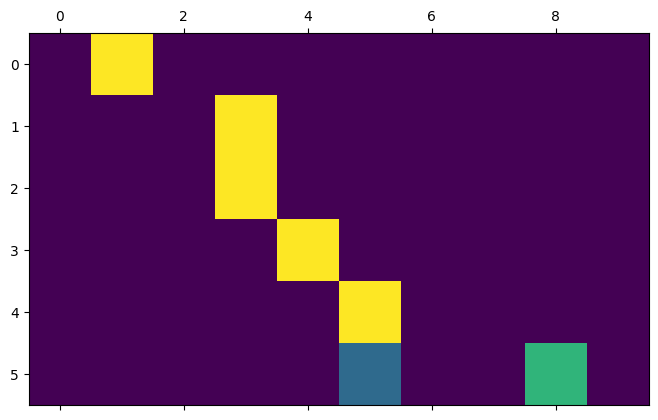

In [ ]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes
and labels:




This code block defines two functions showAttention and evaluateAndShowAttention. showAttention takes in an input sentence, output words, and attentions and displays the attention matrix using matplotlib. evaluateAndShowAttention takes in an input sentence, evaluates it using the encoder-decoder model (encoder1 and attn_decoder1), gets the output words and attention weights, and displays them using showAttention. It then prints the input and output sentences. The function is called four times with different input sentences.






input = elle a cinq ans de moins que moi .
output = she is two years younger than me . <EOS>


<ipython-input-24-9b51ff8fc28e>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-24-9b51ff8fc28e>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


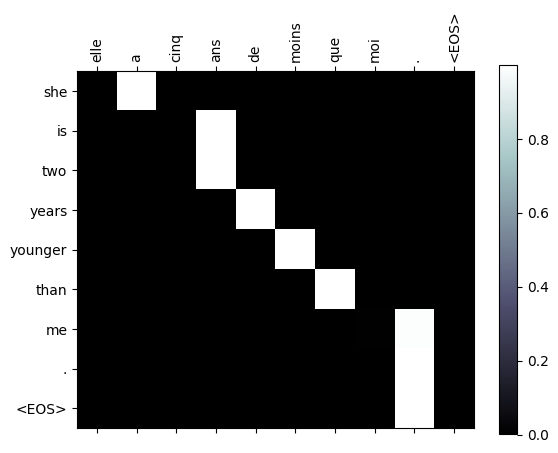

input = elle est trop petit .
output = she s too by to me . <EOS>


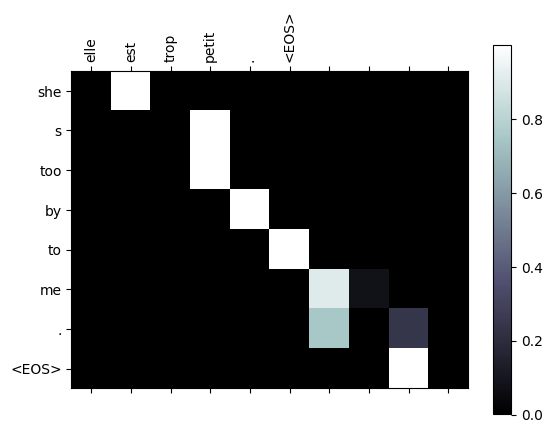

input = je ne crains pas de mourir .
output = i m not scared of dying . <EOS>


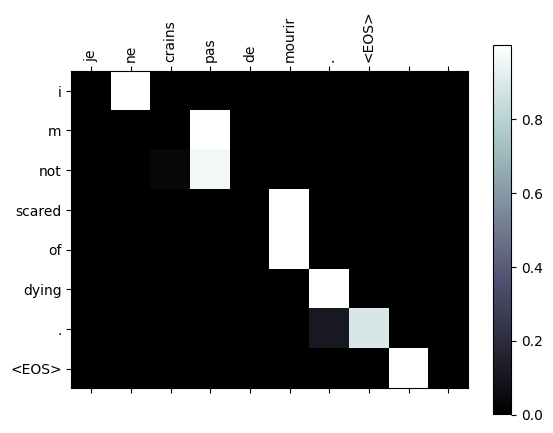

input = c est un jeune directeur plein de talent .
output = he s a talented young director . <EOS>


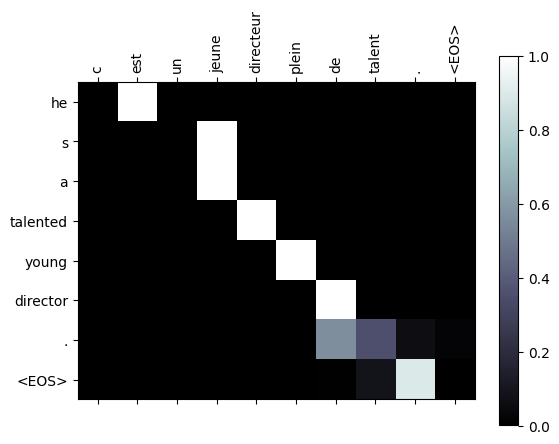

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")